<a href="https://colab.research.google.com/github/hakanskn/Prostate-Cancer-Detection/blob/main/Prostate_Cancer_Detection_by_Feature_Extraction_from_CNN_%2B_SVM_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARIES & CONFIGS

## GPU Info

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 12 21:37:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Drive Mount Code

In [2]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# %cd /content
# !mkdir drive
# %cd drive
# !mkdir MyDrive
# %cd ..
# %cd ..
# !google-drive-ocamlfuse /content/drive/MyDrive

## Libraries

In [3]:
%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D, Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM
from keras import models
import tensorflow as tf
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from tensorflow.keras.optimizers import *
import glob
from pathlib import Path
from PIL import Image
import PIL
import copy
from tensorflow import keras
from keras.utils.layer_utils import count_params

from tensorflow.python.keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
import pydot
import graphviz

from keras.models import model_from_json
!pip install ipython-autotime
%load_ext autotime


!pip install tensorflow_addons
import tensorflow_addons as tfa

from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *

%matplotlib inline
import datetime
import time
import gc
import shutil

from sklearn.model_selection import KFold, StratifiedKFold

!pip install -U tensorboard-plugin-profile

# IGNORING UNNECESSARRY WARNINGS

filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)

time: 21.2 s (started: 2023-07-12 21:37:30 +00:00)


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

print('TF Version:', tf.__version__)
print('TFA Version:', tfa.__version__)

1 Physical GPUs, 1 Logical GPUs
TF Version: 2.12.0
TFA Version: 0.21.0
time: 3.57 s (started: 2023-07-12 21:37:51 +00:00)


# VARIABLES & HYPERPARAMETERS

In [6]:
BATCH_SIZE = 32 # 64
EPOCHS = 20
LR = 0.007 # 0.003
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
NUM_CLASSES = 2
_SPLIT_RATE = 0.9

_AUGMENTED = "TRUE"
AUGMENT_RATE_PER_CLASS = 1.00

data_type = 'Prostat'
model_name = 'DenseNet121_tuned'


_DESC = 'malign_augmentation_100'


CV_PARTS = 5

RANDOM_STATE = 42

#/content/drive/MyDrive/HAKANSKN - DR/Dersler/Tıpta Bilişim/Proje/Prostat

root_path = '/content/drive/MyDrive/HAKANSKN - DR/Dersler/Tıpta Bilişim/Proje/' + data_type + '/'
# comparison_save_path = '/content/drive/MyDrive/HAKANSKN - DR/Dersler/Tıpta Bilişim/Proje/Results/' + model_name + '/' + data_type + '_' + model_name + '.xlsx'
# root_folder_to_save = '/content/drive/MyDrive/HAKANSKN - DR/Dersler/Tıpta Bilişim/Proje/Results/' #root_path + 'Results/'
BENIGN_DIR = root_path + 'BENIGN'
MALIGN_DIR = root_path + 'MALIGN'

model_name_to_save = '_ep_' + str(EPOCHS) + '_bs_' + str(BATCH_SIZE)
datetime_suffix = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
print(datetime_suffix)

2023_07_12_21_38_57
time: 20.5 ms (started: 2023-07-12 21:38:57 +00:00)


# DATA SETTINGS

In [7]:
Benign_Data_Path1 = Path(BENIGN_DIR)
Malign_Data_Path1 = Path(MALIGN_DIR)

Benign_Data_Path = list({p.resolve() for p in Path(Benign_Data_Path1).glob("**/*") if p.suffix in [".jpg", ".png", ".jpeg"]})
Malign_Data_Path = list({p.resolve() for p in Path(Malign_Data_Path1).glob("**/*") if p.suffix in [".jpg", ".png", ".jpeg"]})

Benign_Data_Path = sorted(Benign_Data_Path)
Malign_Data_Path = sorted(Malign_Data_Path)

All_List = []

for Benign_JPG in Benign_Data_Path:
    All_List.append(Benign_JPG)

for Malign_JPG in Malign_Data_Path:
    All_List.append(Malign_JPG)


JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], All_List))

print("Benign COUNTING: ", JPG_Labels.count("BENIGN"))
print("Malign COUNTING: ", JPG_Labels.count("MALIGN"))

JPG_Path_Series = pd.Series(All_List,name="FILE").astype(str)
JPG_Category_Series = pd.Series(JPG_Labels,name="CATEGORY")

Main_Train_Data = pd.concat([JPG_Path_Series,JPG_Category_Series],axis=1)

# Main_Train_Data2 = Main_Train_Data[Main_Train_Data['FILE'].str.contains('set2_')]

# SHUFFLING
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)



Benign COUNTING:  2054
Malign COUNTING:  841
time: 23.9 s (started: 2023-07-12 21:39:10 +00:00)


In [ ]:
Benign_Data_Path[:3]

In [ ]:
Malign_Data_Path[:3]

In [10]:
# train_data,test_data = train_test_split(Main_Train_Data,train_size=_SPLIT_RATE, random_state = RANDOM_STATE, stratify = JPG_Category_Series)
train_data,test_data = train_test_split(Main_Train_Data,train_size=_SPLIT_RATE, random_state = RANDOM_STATE, stratify = Main_Train_Data.CATEGORY)

print("train_data.shape: ", train_data.shape)
print("-----"*20)

print("test_data.shape: ", test_data.shape)
print("-----"*20)

# print("train_data first 3 rows:")
# print(train_data.iloc[0:3, 0].values)
# print("-----"*20)

# print("test_data first 3 rows:")
# print(test_data.iloc[0:3, 0].values)
# print("-----"*20)

train_data.shape:  (2605, 2)
----------------------------------------------------------------------------------------------------
test_data.shape:  (290, 2)
----------------------------------------------------------------------------------------------------
time: 12.7 ms (started: 2023-07-12 21:39:34 +00:00)


In [11]:
test_data.to_csv("test_data.csv", index=False)

time: 9.85 ms (started: 2023-07-12 21:39:40 +00:00)


# DATA AUGMENTATION

In [12]:
!rm -rf aug_images

time: 104 ms (started: 2023-07-12 21:39:43 +00:00)


In [13]:
train_data['CATEGORY'].unique().tolist()

['BENIGN', 'MALIGN']

time: 5.43 ms (started: 2023-07-12 21:39:43 +00:00)


In [14]:
start_time = datetime.datetime.now()

import albumentations as A

augment_func_count = 4

#category_list = train_data['CATEGORY'].unique().tolist()
category_list = ['MALIGN']

if os.path.exists('aug_images'):
    pass
else:
    os.mkdir('aug_images')

for item in category_list:
  if os.path.exists('aug_images/' + item):
    pass
  else:
    os.mkdir('aug_images/' + item)

print("-----"*20)
for item in category_list:

  print('augmentation for class :' + item)
  df_class = train_data[train_data['CATEGORY'] == item]
  print(item + ' sample count: ' + str(df_class.shape[0]))
  augment_count_per_class = df_class.shape[0] * AUGMENT_RATE_PER_CLASS

  augment_count_per_class = round(augment_count_per_class/augment_func_count)*augment_func_count

  print(item + ' augmentation count: ' + str(augment_count_per_class))
  df_class_augmentation, _ = train_test_split(df_class, train_size=int(augment_count_per_class), random_state=RANDOM_STATE)
  augment_count_per_func = int(augment_count_per_class / augment_func_count)
  print('augmentation count per function for ' + item + ': ' + str(augment_count_per_func))
  print("-----"*20)

  for i in range(augment_count_per_func):

    selected_item1 = df_class_augmentation.head(1)
    df_class_augmentation.drop(selected_item1.index, inplace=True)
    #print(str(i+1) + ': ' + selected_item1.iloc[0, 0])

    selected_item2 = df_class_augmentation.head(1)
    df_class_augmentation.drop(selected_item2.index, inplace=True)
    #print(str(i+1) + ': ' + selected_item2.iloc[0, 0])

    selected_item3 = df_class_augmentation.head(1)
    df_class_augmentation.drop(selected_item3.index, inplace=True)
    #print(str(i+1) + ': ' + selected_item3.iloc[0, 0])

    # selected_item4 = df_class_augmentation.head(1)
    # df_class_augmentation.drop(selected_item4.index, inplace=True)
    #print(str(i+1) + ': ' + selected_item4.iloc[0, 0])

    selected_item5 = df_class_augmentation.head(1)
    df_class_augmentation.drop(selected_item5.index, inplace=True)
    #print(str(i+1) + ': ' + selected_item5.iloc[0, 0])

    # Rotate ---------------------------------------------------------------------------------------------
    transform = A.Compose([
      A.Rotate(30, interpolation=cv2.INTER_NEAREST, always_apply=True)
    ])

    # Read an image with OpenCV and convert it to the RGB colorspace
    image = cv2.imread(selected_item1.iloc[0, 0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Augment an image
    transformed = transform(image=image)
    transformed_image = transformed["image"]

    filename, _extension = os.path.splitext(os.path.basename(selected_item1.iloc[0, 0]))
    cv2.imwrite('aug_images/' + item + '/' + filename + '_rotated_image_' + str(i+1) + _extension, transformed_image)


    #HorizontalFlip ---------------------------------------------------------------------------------------
    transform = A.Compose([
      A.HorizontalFlip(always_apply=True)
    ])

    # Read an image with OpenCV and convert it to the RGB colorspace
    image = cv2.imread(selected_item2.iloc[0, 0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Augment an image
    transformed = transform(image=image)
    transformed_image = transformed["image"]

    filename, _extension = os.path.splitext(os.path.basename(selected_item2.iloc[0, 0]))
    cv2.imwrite('aug_images/' + item + '/' + filename + '_horizontalflipped_image_' + str(i+1) + _extension, transformed_image)

    #Blur ----------------------------------------------------------------------------------------------
    transform = A.Compose([
      A.Blur(blur_limit=3, always_apply=True)
    ])

    # Read an image with OpenCV and convert it to the RGB colorspace
    image = cv2.imread(selected_item3.iloc[0, 0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Augment an image
    transformed = transform(image=image)
    transformed_image = transformed["image"]

    filename, _extension = os.path.splitext(os.path.basename(selected_item3.iloc[0, 0]))
    cv2.imwrite('aug_images/' + item + '/' + filename + '_blurred_image_' + str(i+1) + _extension, transformed_image)


    #CenterCrop -------------------------------------------------------------------------------------------

    # Read an image with OpenCV and convert it to the RGB colorspace
    # image = cv2.imread(selected_item4.iloc[0, 0])
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # if image.shape[0] <= IMG_HEIGHT or image.shape[1] <= IMG_WIDTH:
    #   transform = A.Compose([
    #     #A.CenterCrop(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True)
    #     #A.CenterCrop(height=50, width=50, always_apply=True),
    #     A.RandomCrop(height=image.shape[0], width=image.shape[1], always_apply=True)
    #   ])
    # else:
    #   transform = A.Compose([
    #     #A.CenterCrop(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True)
    #     #A.CenterCrop(height=50, width=50, always_apply=True),
    #     A.RandomCrop(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True)
    #   ])

    # # Augment an image
    # transformed = transform(image=image)
    # transformed_image = transformed["image"]

    # filename, _extension = os.path.splitext(os.path.basename(selected_item4.iloc[0, 0]))
    # cv2.imwrite('aug_images/' + item + '/' + filename + '_centercropped_image_' + str(i+1) + _extension, transformed_image)


    # ShiftScaleRotate
    transform = A.Compose([
      A.ShiftScaleRotate(always_apply=True)
    ])

    # Read an image with OpenCV and convert it to the RGB colorspace
    image = cv2.imread(selected_item5.iloc[0, 0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Augment an image
    transformed = transform(image=image)
    transformed_image = transformed["image"]

    filename, _extension = os.path.splitext(os.path.basename(selected_item5.iloc[0, 0]))
    cv2.imwrite('aug_images/' + item + '/' + filename + '_shiftscalerotate_image_' + str(i+1) + _extension, transformed_image)

  print("-----"*20)
  print("-----"*20)
end_time = datetime.datetime.now()

td = end_time - start_time
_elapsed_test_time = str(td)

print(_elapsed_test_time)

----------------------------------------------------------------------------------------------------
augmentation for class :MALIGN
MALIGN sample count: 757
MALIGN augmentation count: 756
augmentation count per function for MALIGN: 189
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
0:00:20.368922
time: 20.4 s (started: 2023-07-12 21:39:44 +00:00)


In [ ]:
!zip -r "aug_images.zip" "aug_images/"

In [16]:
Benign_Data_Path2 = Path('aug_images/BENIGN')
Malign_Data_Path2 = Path('aug_images/MALIGN')

Benign_Data_Path3 = list({p.resolve() for p in Path(Benign_Data_Path2).glob("**/*") if p.suffix in [".jpg", ".png", ".jpeg"]})
Malign_Data_Path3 = list({p.resolve() for p in Path(Malign_Data_Path2).glob("**/*") if p.suffix in [".jpg", ".png", ".jpeg"]})

Benign_Data_Path3 = sorted(Benign_Data_Path3)
Malign_Data_Path3 = sorted(Malign_Data_Path3)

All_List2 = []

for Benign_JPG in Benign_Data_Path3:
    All_List2.append(Benign_JPG)

for Malign_JPG in Malign_Data_Path3:
    All_List2.append(Malign_JPG)


JPG_Labels2 = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], All_List2))

print("BENIGN COUNTING AT AUGMENTED DATA: ", JPG_Labels2.count("BENIGN"))
print("MALIGN COUNTING AT AUGMENTED DATA: ", JPG_Labels2.count("MALIGN"))

print("-----"*20)

JPG_Path_Series2 = pd.Series(All_List2,name="FILE").astype(str)
JPG_Category_Series2 = pd.Series(JPG_Labels2,name="CATEGORY")

Main_Train_Data2 = pd.concat([JPG_Path_Series2,JPG_Category_Series2],axis=1)

train_data_with_aug = pd.concat([Main_Train_Data2, train_data], axis=0)

train_data_with_aug = train_data_with_aug.sample(frac=1).reset_index(drop=True)

print("train_data_with_aug.shape: ", train_data_with_aug.shape)
print("-----"*20)

BENIGN COUNTING AT AUGMENTED DATA:  0
MALIGN COUNTING AT AUGMENTED DATA:  756
----------------------------------------------------------------------------------------------------
train_data_with_aug.shape:  (3361, 2)
----------------------------------------------------------------------------------------------------
time: 57.8 ms (started: 2023-07-12 21:40:06 +00:00)


In [17]:
train_data_with_aug["CATEGORY"].value_counts()

BENIGN    1848
MALIGN    1513
Name: CATEGORY, dtype: int64

time: 7.18 ms (started: 2023-07-12 21:40:06 +00:00)


# FEATURE EXTRACTION

In [18]:
train_data_with_aug.columns

Index(['FILE', 'CATEGORY'], dtype='object')

time: 4.93 ms (started: 2023-07-12 21:40:06 +00:00)


In [19]:
densenet_model = keras.applications.densenet
conv_model = densenet_model.DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
#conv_model.trainable = True

for layers in conv_model.layers:
    layers.trainable=False

print(conv_model.output)

29084464/29084464 [==============================] - 2s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")
time: 5.93 s (started: 2023-07-12 21:40:06 +00:00)


In [20]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

time: 1.09 ms (started: 2023-07-12 21:40:12 +00:00)


In [ ]:
feature_list = []
for path in train_data_with_aug['FILE'].to_numpy():
    x = load_img(path,target_size=(IMG_WIDTH,IMG_WIDTH))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = conv_model.predict(img_array)
    feature_list.append(features)

feat_lst = np.reshape(feature_list,(-1,7*7*1024))

1/1 [==============================] - 0s 29ms/step
time: 31min 27s (started: 2023-07-04 20:45:38 +00:00)


In [ ]:
print(feat_lst.shape)

(3361, 50176)
time: 561 µs (started: 2023-07-04 21:17:05 +00:00)


In [ ]:
gender = {'BENIGN': 0,'MALIGN': 1}
y = [gender[item] for item in train_data_with_aug.CATEGORY]
len(y)

3361

time: 7.08 ms (started: 2023-07-04 21:17:05 +00:00)


In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(feat_lst, y, test_size=0.2, random_state=RANDOM_STATE)

glm = LogisticRegression(C=0.1)
glm.fit(X_train,y_train)

LogisticRegression(C=0.1)

time: 27.7 s (started: 2023-07-04 21:17:05 +00:00)


In [ ]:
print("Accuracy on validation set using Logistic Regression: ",glm.score(X_test,y_test))

Accuracy on validation set using Logistic Regression:  0.962852897473997
time: 151 ms (started: 2023-07-04 21:17:33 +00:00)


## Default SVM Classifier

In [ ]:
# import SVC classifier
from sklearn.svm import SVC

# import metrics to compute accuracy
from sklearn.metrics import accuracy_score

# instantiate classifier with default hyperparameters
svc=SVC()

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9272
time: 4min 27s (started: 2023-07-04 21:17:33 +00:00)


In [ ]:
# instantiate classifier with rbf kernel and C=100
svc=SVC(C=100.0)

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=100.0 : 0.9911
time: 4min 50s (started: 2023-07-04 21:22:00 +00:00)


In [ ]:
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=1000.0 : 0.9911
time: 4min 51s (started: 2023-07-04 21:26:51 +00:00)


In [ ]:
# make predictions on train set
y_pred_train = svc.predict(X_train)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Model accuracy score with rbf kernel and C=1000.0 : 1.0000
time: 5min 54s (started: 2023-07-04 21:31:43 +00:00)


0.9910846953937593

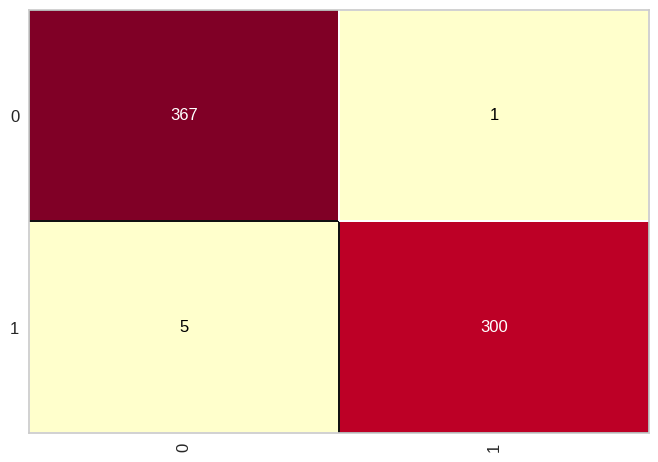

time: 2min 58s (started: 2023-07-04 21:37:37 +00:00)


In [ ]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(svc)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

## Linear Kernel SVM Classifier

In [ ]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0)


# fit classifier to training set
linear_svc.fit(X_train,y_train)


# make predictions on test set
y_pred_test=linear_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with linear kernel and C=1.0 : 0.9688
time: 2min 11s (started: 2023-07-04 21:40:35 +00:00)


In [ ]:
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=100.0)


# fit classifier to training set
linear_svc100.fit(X_train, y_train)


# make predictions on test set
y_pred=linear_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=100.0 : 0.9688
time: 2min 12s (started: 2023-07-04 21:42:46 +00:00)


In [ ]:
# instantiate classifier with linear kernel and C=1000.0
linear_svc1000=SVC(kernel='linear', C=1000.0)


# fit classifier to training set
linear_svc1000.fit(X_train, y_train)


# make predictions on test set
y_pred=linear_svc1000.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=1000.0 : 0.9688
time: 2min 11s (started: 2023-07-04 21:44:59 +00:00)


## Ploynomial Kernel SVM Classifier

In [ ]:
# instantiate classifier with polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0)


# fit classifier to training set
poly_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=poly_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.8915
time: 3min 21s (started: 2023-07-04 21:47:10 +00:00)


In [ ]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0)


# fit classifier to training set
poly_svc100.fit(X_train, y_train)


# make predictions on test set
y_pred=poly_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=100.0 : 0.9658
time: 2min 30s (started: 2023-07-04 21:50:32 +00:00)


In [ ]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc1000=SVC(kernel='poly', C=1000.0)


# fit classifier to training set
poly_svc1000.fit(X_train, y_train)


# make predictions on test set
y_pred=poly_svc1000.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1000.0 : 0.9629
time: 2min 27s (started: 2023-07-04 21:53:02 +00:00)


## Sigmoid Kernel SVM Classifier

In [ ]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0)


# fit classifier to training set
sigmoid_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=sigmoid_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=1.0 : 0.6880
time: 2min 58s (started: 2023-07-04 21:55:30 +00:00)


In [ ]:
# instantiate classifier with sigmoid kernel and C=100.0
sigmoid_svc100=SVC(kernel='sigmoid', C=100.0)


# fit classifier to training set
sigmoid_svc100.fit(X_train,y_train)


# make predictions on test set
y_pred=sigmoid_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=100.0 : 0.6464
time: 2min 4s (started: 2023-07-04 21:58:28 +00:00)


## RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier
rf = RandomForestClassifier()

# fit classifier to training set
rf.fit(X_train,y_train)


# make predictions on test set
y_pred=rf.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with Random Forest : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with Random Forest : 0.9153
time: 31.3 s (started: 2023-07-04 22:00:33 +00:00)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 429}
time: 31min 40s (started: 2023-07-04 22:01:04 +00:00)


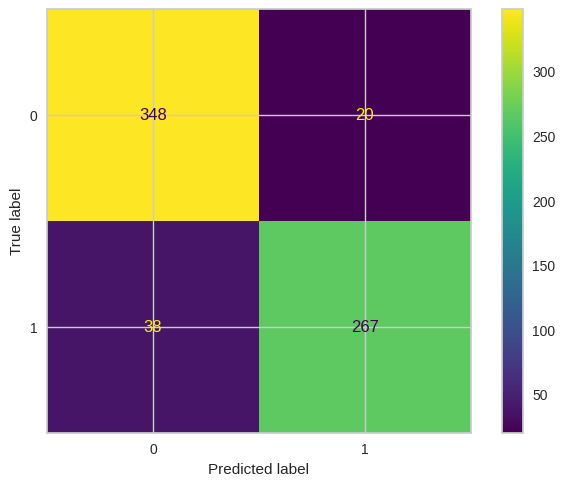

time: 451 ms (started: 2023-07-04 22:32:45 +00:00)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
accuracy_score(y_test, y_pred)

0.9138187221396731

time: 6.18 ms (started: 2023-07-04 22:32:45 +00:00)
